In [3]:
!pip install ultralytics opencv-contrib-python


[INFO] Detecção em imagem concluída.


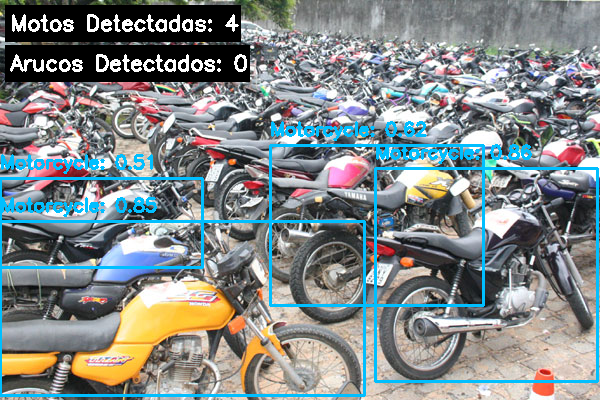

In [4]:
import cv2
import numpy as np
from ultralytics import YOLO
# Em ambientes como o Google Colab, use cv2_imshow. Para execução local,
# comente a linha abaixo e use cv2.imshow() nas chamadas correspondentes.
from google.colab.patches import cv2_imshow

# --- CONFIGURAÇÕES GERAIS ---

# Defina a fonte da mídia:
# 0 para webcam.
# 'caminho/para/seu/video.mp4' para um arquivo de vídeo.
# 'caminho/para/sua/imagem.jpg' ou '.png' para uma imagem.
SOURCE_PATH = '/content/motos pátio.jpg'

# --- CONFIGURAÇÕES YOLO ---
YOLO_MODEL = YOLO('yolov8n.pt')
CLASSES_PARA_DETECTAR = ['motorcycle']
COLOR_MOTO = (255, 191, 0)  # Azul Ciano

# --- CONFIGURAÇÕES ARUCO ---
ARUCO_DICT = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
ARUCO_PARAMS = cv2.aruco.DetectorParameters()
ARUCO_DETECTOR = cv2.aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMS)
COLOR_ARUCO = (0, 255, 0)  # Verde Brilhante

# --- PARÂMETROS DE CÂMERA E DISTÂNCIA ---
REAL_MARKER_SIZE_M = 0.05
CAMERA_MATRIX = np.array([[1000, 0, 640],
                          [0, 1000, 360],
                          [0, 0, 1]], dtype=np.float32)
DIST_COEFFS = np.zeros((4, 1), dtype=np.float32)


def processar_frame(frame):
    """
    Aplica a detecção de motocicletas (YOLO) e marcadores ArUco,
    e exibe contadores para cada um no frame.
    """
    moto_count = 0
    aruco_count = 0

    # 1. DETECÇÃO DE MOTOCICLETAS (YOLO)
    # ------------------------------------
    results = YOLO_MODEL(frame, verbose=False)
    result = results[0]

    for box in result.boxes:
        class_id = int(box.cls[0].item())
        class_name = result.names[class_id]
        confianca = box.conf[0].item()

        if class_name in CLASSES_PARA_DETECTAR and confianca > 0.5:
            # Incrementa o contador de motos
            moto_count += 1
            coords = box.xyxy[0].cpu().numpy().astype(int)
            x1, y1, x2, y2 = coords
            cv2.rectangle(frame, (x1, y1), (x2, y2), COLOR_MOTO, 2)
            label = f'{class_name.capitalize()}: {confianca:.2f}'
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, COLOR_MOTO, 2)

    # 2. DETECÇÃO DE MARCADORES ARUCO
    # ---------------------------------
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejected = ARUCO_DETECTOR.detectMarkers(gray)

    if ids is not None:
        # Atualiza o contador de Arucos
        aruco_count = len(ids)
        cv2.aruco.drawDetectedMarkers(frame, corners, ids, borderColor=COLOR_ARUCO)
        rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(corners, REAL_MARKER_SIZE_M, CAMERA_MATRIX, DIST_COEFFS)

        for i, marker_id in enumerate(ids):
            distancia = tvecs[i][0][2]
            canto_superior_esquerdo = tuple(corners[i][0][0].astype(int))
            id_texto = f"ID: {marker_id[0]}"
            dist_texto = f"Dist: {distancia:.2f} m"
            cv2.putText(frame, id_texto, (canto_superior_esquerdo[0], canto_superior_esquerdo[1] - 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, COLOR_ARUCO, 2)
            cv2.putText(frame, dist_texto, (canto_superior_esquerdo[0], canto_superior_esquerdo[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, COLOR_ARUCO, 2)

    # 3. EXIBIR OS CONTADORES NA TELA
    # ---------------------------------
    # Define a cor e o fundo para o texto dos contadores para melhor visibilidade
    TEXT_COLOR = (255, 255, 255) # Branco
    BG_COLOR = (0, 0, 0) # Preto

    # Texto para o contador de motos
    moto_text = f"Motos Detectadas: {moto_count}"
    (w, h), _ = cv2.getTextSize(moto_text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
    cv2.rectangle(frame, (5, 5), (10 + w, 25 + h), BG_COLOR, -1)
    cv2.putText(frame, moto_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, TEXT_COLOR, 2)

    # Texto para o contador de ArUco
    aruco_text = f"Arucos Detectados: {aruco_count}"
    (w, h), _ = cv2.getTextSize(aruco_text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
    cv2.rectangle(frame, (5, 45), (10 + w, 65 + h), BG_COLOR, -1)
    cv2.putText(frame, aruco_text, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.7, TEXT_COLOR, 2)


    return frame


def run_detection():
    """
    Inicia a captura de mídia (imagem, vídeo ou webcam) e o loop de detecção.
    """
    is_image = any(SOURCE_PATH.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png']) if isinstance(SOURCE_PATH, str) else False

    if is_image:
        frame = cv2.imread(SOURCE_PATH)
        if frame is None:
            print(f"Erro: Não foi possível ler a imagem em '{SOURCE_PATH}'")
            return
        processed_frame = processar_frame(frame)
        print("\n[INFO] Detecção em imagem concluída.")
        cv2_imshow(processed_frame)
        # cv2.imshow("MottuFlow Detection", processed_frame) # Para execução local
        cv2.waitKey(0)
    else:
        cap = cv2.VideoCapture(SOURCE_PATH)
        if not cap.isOpened():
            print(f"Erro: Não foi possível abrir a fonte de vídeo: {SOURCE_PATH}")
            return

        print("\n[INFO] Iniciando detecção. Pressione 'q' na janela para parar.")
        while True:
            ret, frame = cap.read()
            if not ret:
                print("[INFO] Fim do vídeo ou erro na captura.")
                break

            processed_frame = processar_frame(frame)
            cv2_imshow(processed_frame)
            # cv2.imshow("MottuFlow Detection", processed_frame) # Para execução local

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        cap.release()

    cv2.destroyAllWindows()


if __name__ == "__main__":
    run_detection()